In [1]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    download=True  # Ensure the dataset is re-downloaded
)

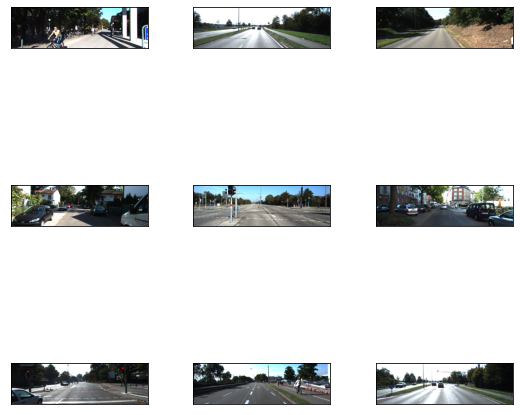

In [3]:
_ = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(9,), dtype=float32, numpy=
array([ 2.42,  1.78, -1.66,  1.77,  1.71, -0.94, -0.99, -1.03, -1.09],
      dtype=float32)>, 'bbox': <tf.Tensor: shape=(9, 4), dtype=float32, numpy=
array([[0.00266667, 0.        , 0.39317334, 0.06189211],
       [0.38578665, 0.33580515, 0.49546668, 0.38442835],
       [0.43546668, 0.52590984, 0.5358933 , 0.5653301 ],
       [0.41269332, 0.3612963 , 0.5004    , 0.40228665],
       [0.43808   , 0.38892916, 0.52386665, 0.42073268],
       [0.35869333, 0.0257971 , 0.45032   , 0.10313205],
       [0.36517334, 0.07033817, 0.45432   , 0.13987118],
       [0.36981332, 0.10436393, 0.46648   , 0.17841385],
       [0.37114668, 0.15296297, 0.46706668, 0.21773753]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(9, 3), dtype=float32, numpy=
array([[1.53, 1.56, 3.58],
       [1.42, 1.54, 3.5 ],
       [1.51, 1.75, 3.78],
       [1.36, 1.51, 4.02],
       [1.74,

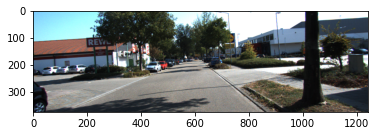

In [5]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

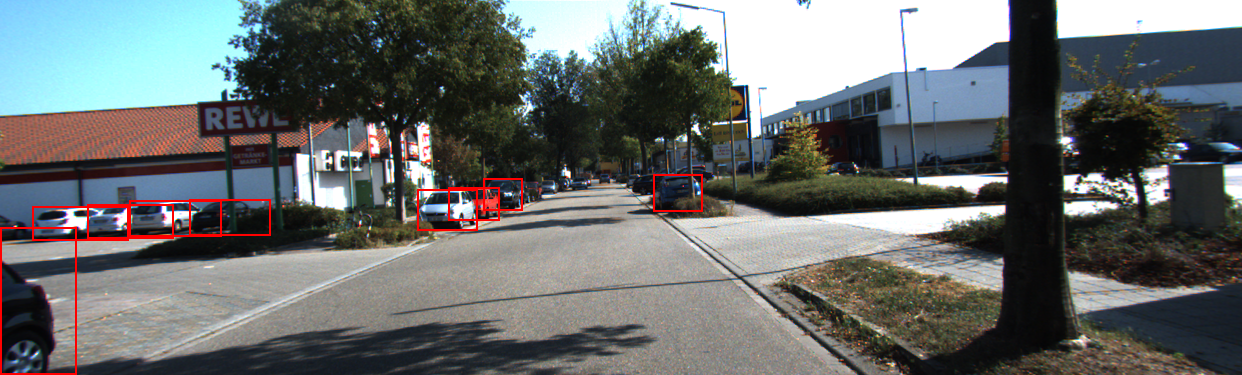

In [6]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

In [7]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

In [8]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

In [9]:
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

In [10]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

In [11]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

In [12]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

In [13]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [14]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

In [15]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

In [16]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

In [17]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

In [18]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

In [19]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

In [20]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

94781440/94765736 [==============================] - 1s 0us/step


In [21]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

In [22]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

In [24]:
import os
import tensorflow as tf

# 쓰기 권한이 있는 경로로 체크포인트 경로 설정
model_dir = '/tmp/aiffel/object_detection/data/checkpoints/'  # '/tmp/' 경로로 변경

# 폴더가 존재하지 않으면 생성
os.makedirs(model_dir, exist_ok=True)

# 콜백 설정 (체크포인트와 얼리 스토핑)
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="val_loss",  # 검증 데이터의 손실을 기준으로 가장 좋은 모델 저장
        save_best_only=True,  # 가장 좋은 모델만 저장
        save_weights_only=True,  # 모델의 가중치만 저장
        verbose=1,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",  # 검증 데이터의 손실을 기준으로 조기 종료
        patience=2,  # 2번의 에폭 동안 개선이 없으면 학습 중단
        verbose=1,
        restore_best_weights=True  # 가장 좋은 가중치를 복원
    )
]

# 에폭 수 설정
epochs = 50  # 충분히 큰 값으로 설정하여 조기 종료가 동작할 수 있도록

# 모델 학습
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)

Epoch 1/50
3173/3173 [==============================] - 1570s 494ms/step - loss: 0.9739 - val_loss: 1.2462

Epoch 00001: val_loss improved from inf to 1.24622, saving model to /tmp/aiffel/object_detection/data/checkpoints/weights_epoch_1
Epoch 2/50
3173/3173 [==============================] - 1576s 496ms/step - loss: 0.7179 - val_loss: 1.1131

Epoch 00002: val_loss improved from 1.24622 to 1.11312, saving model to /tmp/aiffel/object_detection/data/checkpoints/weights_epoch_2
Epoch 3/50
3173/3173 [==============================] - 1576s 496ms/step - loss: 0.5699 - val_loss: 1.0707

Epoch 00003: val_loss improved from 1.11312 to 1.07071, saving model to /tmp/aiffel/object_detection/data/checkpoints/weights_epoch_3
Epoch 4/50
3173/3173 [==============================] - 1577s 497ms/step - loss: 0.4766 - val_loss: 1.0479

Epoch 00004: val_loss improved from 1.07071 to 1.04786, saving model to /tmp/aiffel/object_detection/data/checkpoints/weights_epoch_4
Epoch 5/50
3173/3173 [==============

Epoch 1/50
3173/3173 [==============================] - 1575s 496ms/step - loss: 0.2327 - val_loss: 0.9835

Epoch 00001: val_loss did not improve from 0.97434
Epoch 2/50
3173/3173 [==============================] - 1575s 496ms/step - loss: 0.2067 - val_loss: 0.9954

Epoch 00002: val_loss did not improve from 0.97434
Epoch 3/50
3173/3173 [==============================] - 1576s 496ms/step - loss: 0.1835 - val_loss: 1.0109

Epoch 00003: val_loss did not improve from 0.97434
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping


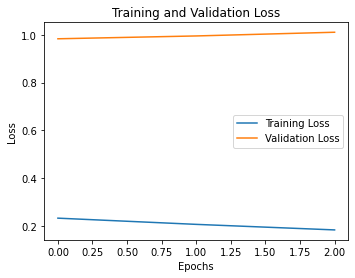

In [25]:
import matplotlib.pyplot as plt

# 학습 결과 시각화 함수
def plot_training_history(history):
    # 훈련 손실 및 검증 손실 시각화
    plt.figure(figsize=(12, 4))
    
    # 손실 시각화
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 정확도 시각화 (모델이 'accuracy' 메트릭을 사용하는 경우)
    if 'accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.show()

# 모델 학습 후 history 객체로 반환된 결과 시각화
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)

# 학습 결과 시각화 호출
plot_training_history(history)

In [26]:
model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)

if latest_checkpoint:
    model.load_weights(latest_checkpoint)
    print(f"Loaded weights from {latest_checkpoint}")
else:
    print("No checkpoint found. Please check the model directory.")

Loaded weights from /aiffel/aiffel/object_detection/data/checkpoints/weights_epoch_1


In [27]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.3,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

In [28]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [29]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [30]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

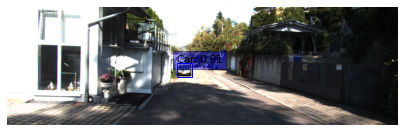

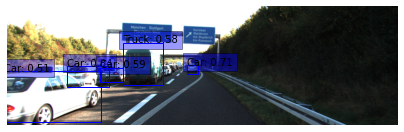

In [31]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

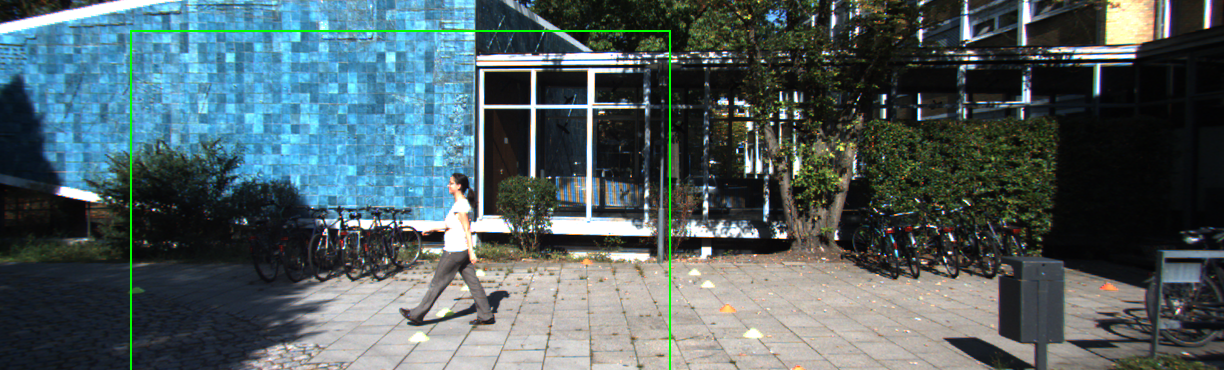

In [32]:
from PIL import Image, ImageDraw
import os

# 이미지 파일 경로
img_path = os.getenv('HOME') + '/aiffel/object_detection/data/stop_2.png'
img = Image.open(img_path)

# ImageDraw 객체 생성
draw = ImageDraw.Draw(img)

# 사각형 그리기 (좌상단 x, y, 우하단 x, y 좌표)
draw.rectangle((130, 30, 670, 450), outline=(0, 255, 0), width=2)

# 이미지 표시
img.show()

In [33]:
import tensorflow as tf
from tensorflow import keras

# 총 output: object_prob(1), bbox_coord(4), class_prob(3)
output_num = 1 + 4 + 3

# ResNet50의 feature extractor로 사용할 입력 텐서
input_tensor = keras.layers.Input(shape=(224, 224, 3), name='image')
base_model = keras.applications.ResNet50(
    input_tensor=input_tensor,
    include_top=False,    
    weights='imagenet',
    pooling=None,
)

# ResNet의 출력에 추가 CNN 및 Dense Layer 추가
x = base_model.output

# Feature map을 CNN 레이어로 변환
x = keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.BatchNormalization()(x)

# Global Average Pooling을 적용하여 Feature를 벡터로 변환
x = keras.layers.GlobalAveragePooling2D()(x)

# Dense Layer를 통해 localization 관련 예측값 도출
output = keras.layers.Dense(output_num, activation='linear', name='output')(x)

# Localization 모델 구성
localize_model = keras.models.Model(inputs=input_tensor, outputs=output)

# 모델 요약 정보 출력
localize_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           image[0][0]                      
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

# 1. 자율주행 시스템 만들기
- 입력으로 이미지 경로를 받습니다.
- 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
- 조건은 다음과 같습니다.
    - 사람이 한 명 이상 있는 경우
    - 차량의 크기(width or height)가 300px이상인 경우

Detected object: Pedestrian, width: 68.81134033203125, height: 154.64865112304688
Pedestrian detected!


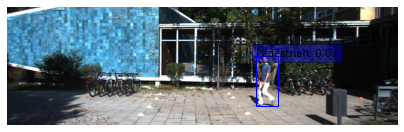

Stop


In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

img_path = os.getenv('HOME') + '/aiffel/object_detection/data/stop_1.png'

def visualize_detections(image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    
    for box, _cls, score in zip(boxes, classes, scores):
        text = f"{_cls}: {score:.2f}"
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle([origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth)
        ax.add_patch(patch)
        ax.text(origin_x, origin_y, text, bbox={"facecolor": color, "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True)
    
    plt.show()
    return ax

def self_drive_assist(img_path, size_limit=300):
    # 1. 이미지를 불러와서 전처리
    image = Image.open(img_path)
    input_image, ratio = prepare_image(np.array(image))

    # 2. 탐지 모델로부터 예측값을 얻기
    detections = inference_model.predict(input_image)
    
    # 3. 유효한 탐지 개수 및 탐지된 객체들 정보 가져오기
    num_detections = int(detections.valid_detections[0])
    boxes = detections.nmsed_boxes[0][:num_detections] / ratio
    classes = detections.nmsed_classes[0][:num_detections]
    scores = detections.nmsed_scores[0][:num_detections]

    # 4. 조건에 맞는지 확인
    person_detected = False
    vehicle_large = False
    
    int2str = dataset_info.features["objects"]["type"].int2str
    
    for i in range(num_detections):
        class_name = int2str(int(classes[i]))
        box = boxes[i]
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1

        # 디버깅: 탐지된 클래스와 크기 출력
        print(f"Detected object: {class_name}, width: {width}, height: {height}")

        # 사람이 탐지된 경우 (Pedestrian 포함)
        if class_name == 'Person' or class_name == 'Pedestrian':
            print("Pedestrian detected!")
            person_detected = True

        # 차량 크기가 300px 이상인 경우
        if class_name == 'Car' and (width >= size_limit or height >= size_limit):
            print(f"Large vehicle detected! Width: {width}, Height: {height}")
            vehicle_large = True
    
    # 이미지와 탐지 결과를 시각화
    visualize_detections(image, boxes, [int2str(int(c)) for c in classes], scores)

    # 5. 정지 조건을 만족하는지 확인
    if person_detected or vehicle_large:
        return "Stop"
    else:
        return "Go"

# 함수 실행
print(self_drive_assist(img_path))

Detected object: Pedestrian, width: 72.82888793945312, height: 159.58834838867188
Pedestrian detected!


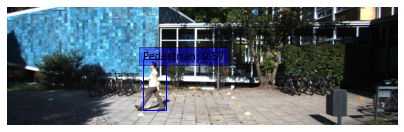

Stop


In [35]:
img_path = os.getenv('HOME') + '/aiffel/object_detection/data/stop_2.png'
print(self_drive_assist(img_path))

Detected object: Car, width: 313.27099609375, height: 163.16989135742188
Large vehicle detected! Width: 313.27099609375, Height: 163.16989135742188
Detected object: Car, width: 120.60357666015625, height: 40.12074279785156


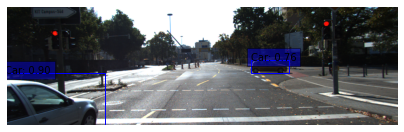

Stop


In [36]:
img_path = os.getenv('HOME') + '/aiffel/object_detection/data/stop_3.png'
print(self_drive_assist(img_path))

Detected object: Car, width: 34.210693359375, height: 28.68206787109375
Detected object: Car, width: 41.748291015625, height: 22.809036254882812
Detected object: Truck, width: 167.60328674316406, height: 101.81283569335938


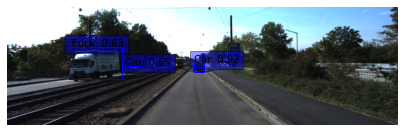

Go


In [37]:
img_path = os.getenv('HOME') + '/aiffel/object_detection/data/go_1.png'
print(self_drive_assist(img_path))

Detected object: Car, width: 57.884033203125, height: 33.069854736328125
Detected object: Car, width: 38.28863525390625, height: 39.86442565917969


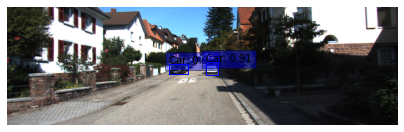

Go


In [38]:
img_path = os.getenv('HOME') + '/aiffel/object_detection/data/go_2.png'
print(self_drive_assist(img_path))

Detected object: Car, width: 27.84405517578125, height: 19.94976806640625


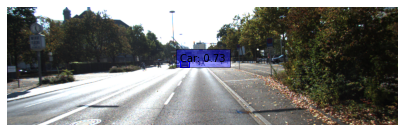

Go


In [39]:
img_path = os.getenv('HOME') + '/aiffel/object_detection/data/go_3.png'
print(self_drive_assist(img_path))

# 2. 자율주행 시스템 평가하기
- 아래 test_system() 를 통해서 위에서 만든 함수를 평가해봅시다. 
- 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

Detected object: Pedestrian, width: 68.81134033203125, height: 154.64865112304688
Pedestrian detected!


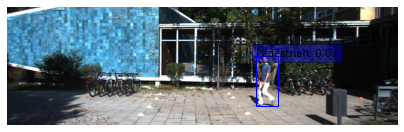

Detected object: Pedestrian, width: 72.82888793945312, height: 159.58834838867188
Pedestrian detected!


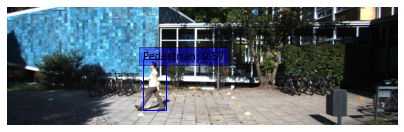

Detected object: Car, width: 313.27099609375, height: 163.16989135742188
Large vehicle detected! Width: 313.27099609375, Height: 163.16989135742188
Detected object: Car, width: 120.60357666015625, height: 40.12074279785156


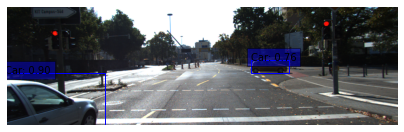

Detected object: Car, width: 133.0936279296875, height: 43.0721435546875
Detected object: Car, width: 260.11541748046875, height: 125.18814849853516
Detected object: Car, width: 111.26324462890625, height: 79.34585571289062
Detected object: Van, width: 81.02197265625, height: 75.35160827636719


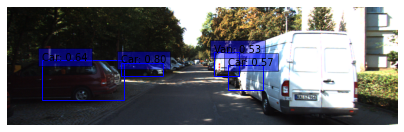

Detected object: Car, width: 52.86138916015625, height: 31.683303833007812
Detected object: Car, width: 113.9566650390625, height: 71.04878234863281
Detected object: Car, width: 375.5784912109375, height: 192.3812713623047
Large vehicle detected! Width: 375.5784912109375, Height: 192.3812713623047


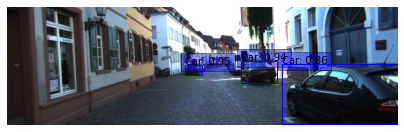

Detected object: Car, width: 34.210693359375, height: 28.68206787109375
Detected object: Car, width: 41.748291015625, height: 22.809036254882812
Detected object: Truck, width: 167.60328674316406, height: 101.81283569335938


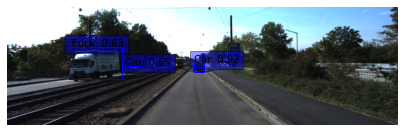

Detected object: Car, width: 57.884033203125, height: 33.069854736328125
Detected object: Car, width: 38.28863525390625, height: 39.86442565917969


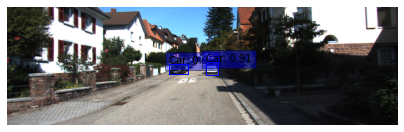

Detected object: Car, width: 27.84405517578125, height: 19.94976806640625


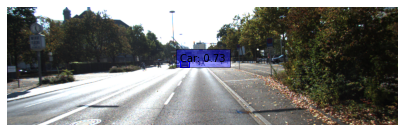

Detected object: Car, width: 100.0167236328125, height: 66.6167984008789


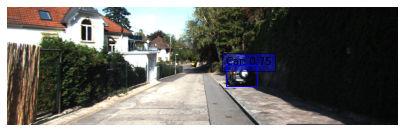

Detected object: Car, width: 45.1373291015625, height: 26.334930419921875
Detected object: Car, width: 221.14125061035156, height: 93.21376037597656
Detected object: Car, width: 172.11087036132812, height: 65.16201782226562


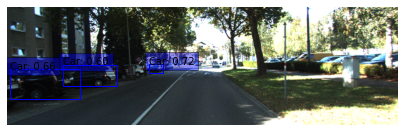

90점입니다.


In [40]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)